In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

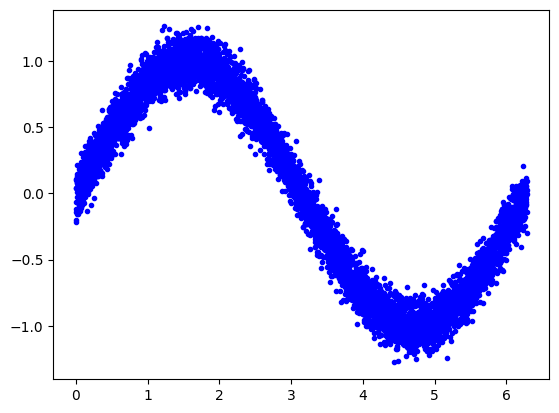

In [2]:
x_values = np.arange(0,2*math.pi,0.001)

np.random.shuffle(x_values)
y_values = np.sin(x_values)
y_values += 0.1 * np.random.randn(*y_values.shape)

x_train,x_test,y_train,y_test = train_test_split(x_values,y_values,test_size=0.3)

plt.plot(x_values, y_values, 'b.')
plt.show()


In [3]:
model = tf.keras.Sequential()
model.add(Dense(32, activation='relu', input_shape=(1,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='linear'))

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 609 (2.38 KB)
Trainable params: 609 (2.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [4]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
35/35 [==============================] - 6s 29ms/step - loss: 0.7804 - mae: 0.7576 - val_loss: 0.4751 - val_mae: 0.6026
Epoch 2/100
35/35 [==============================] - 1s 15ms/step - loss: 0.4334 - mae: 0.5658 - val_loss: 0.4060 - val_mae: 0.5535
Epoch 3/100
35/35 [==============================] - 0s 11ms/step - loss: 0.3632 - mae: 0.5193 - val_loss: 0.3344 - val_mae: 0.4997
Epoch 4/100
35/35 [==============================] - 0s 10ms/step - loss: 0.2970 - mae: 0.4694 - val_loss: 0.2704 - val_mae: 0.4527
Epoch 5/100
35/35 [==============================] - 0s 14ms/step - loss: 0.2403 - mae: 0.4249 - val_loss: 0.2190 - val_mae: 0.4103
Epoch 6/100
35/35 [==============================] - 1s 15ms/step - loss: 0.1977 - mae: 0.3877 - val_loss: 0.1821 - val_mae: 0.3764
Epoch 7/100
35/35 [==============================] - 1s 15ms/step - loss: 0.1695 - mae: 0.3607 - val_loss: 0.1600 - val_mae: 0.3520
Epoch 8/100
35/35 [==============================] - 1s 15ms/step - loss: 0.

In [5]:
x_test = np.array(0.5*math.pi).astype('float32').reshape(1,1)
print(model.predict(x_test))

1/1 [==============================] - 0s 108ms/step
[[1.0016772]]


In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()
open("sine_model_quantized.tflite", "wb").write(tflite_model)

4320

In [7]:
# #tflite推理

x = np.array(0.5*math.pi).astype('float32').reshape(1,1)

interpreter = tf.lite.Interpreter(model_path="sine_model_quantized.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


interpreter.resize_tensor_input(input_details[0]['index'], x.shape)
interpreter.allocate_tensors()

interpreter.set_tensor(input_details[0]['index'], x)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

print(output_data)


[[1.001677]]


In [8]:
!apt-get -qq install xxd
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc